In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Necessary imports
import pandas as pd
import numpy as np
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Activation, Dropout, Dense, Input, Embedding
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import gensim
import nltk
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
# Load datasets
d_path = '/content/drive/MyDrive/Internship/d_tweets.csv'
non_d_path = '/content/drive/MyDrive/Internship/non_d_tweets.csv'

d_tweet_df = pd.read_csv(d_path)
non_d_tweet_df = pd.read_csv(non_d_path)

# Remove empty rows
d_tweet_df = d_tweet_df[d_tweet_df['tweet'].notna()]
non_d_tweet_df = non_d_tweet_df[non_d_tweet_df['tweet'].notna()]

# Assign labels and combine datasets
non_d_tweet_df['label'] = 0
d_tweet_df['label'] = 1
tweet_df = pd.concat([d_tweet_df[['tweet', 'label']], non_d_tweet_df[['tweet', 'label']]])
tweet_df = tweet_df.sample(frac=1).reset_index(drop=True)

In [16]:
# Undersample the majority class
majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

# Combine the undersampled majority class with the minority class
tweet_df = pd.concat([majority_undersampled, minority_class])

# Shuffle the balanced dataset
tweet_df = shuffle(tweet_df).reset_index(drop=True)
print(tweet_df['label'].value_counts())


label
0    3496
1    3496
Name: count, dtype: int64


In [19]:

nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))

def text_preprocess(text):
    try:
        text_nlp = nlp(text)
        lemmas = [token.lemma_ for token in text_nlp
                  if not token.is_punct and token.is_ascii and token.text not in stop_words]
        cleaned_text = " ".join(lemmas)
        return re.sub(r'\S*\d\S*', '', cleaned_text).strip()
    except Exception as e:
        print(f"Error processing text: {str(e)}")
        return text

tweet_df['cleaned_tweet'] = tweet_df['tweet'].apply(text_preprocess)


In [20]:
# Parameters for tokenization
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 100
WORD2VEC_DIR = '/content/drive/MyDrive/Internship/Word2Vec-twitter-100'

# Tokenization
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(tweet_df['cleaned_tweet'])
sequences = tokenizer.texts_to_sequences(tweet_df['cleaned_tweet'])
word_index = tokenizer.word_index
data = pad_sequences(sequences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

# Labels
labels = tweet_df['label'].values

# Shuffle data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]


In [40]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(tweet_df['cleaned_tweet'], tweet_df['label'], test_size=0.2, random_state=42)


In [41]:
import pandas as pd

pd.Series(y_train).value_counts()

,count
label,
1,2809
0,2784


In [46]:
# Load Word2Vec embeddings using Gensim
!pip install gensim
import gensim
import numpy as np

embeddings_index = {}
print('Loading Word2Vec embeddings...')
try:
    # Load the pickled model
    w2v_model = gensim.models.KeyedVectors.load(WORD2VEC_DIR)
    print("Word2Vec embeddings loaded successfully.")

    # Create the embeddings index from the Word2Vec model
    for word in w2v_model.key_to_index:
        embeddings_index[word] = w2v_model[word]

except Exception as e:
    print(f"Error loading Word2Vec embeddings: {e}")

# Ensure all token IDs in X_train are present in word_index
# Get the maximum token ID in X_train
# Instead of using X_train directly, use the tokenized sequences from 'data'
max_token_id = data.max()

# Check if any token ID exceeds the vocabulary size
if max_token_id >= len(word_index) + 1:
    print(f"Warning: Maximum token ID ({max_token_id}) exceeds vocabulary size ({len(word_index)}).")
    # You may need to adjust your tokenization/vocabulary creation process.
    # For now, we'll handle it by ensuring all token IDs are within the vocabulary range:
    data = np.clip(data, 0, len(word_index)) # clip token IDs to the vocabulary range
    # if X_test is available, perform the same clipping, but first you need to tokenize it
    # This is just an example, adjust to your specific needs
    # if 'X_test' in locals() and X_test is not None:
    #     X_test_sequences = tokenizer.texts_to_sequences(X_test)
    #     X_test = pad_sequences(X_test_sequences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
    #     X_test = np.clip(X_test, 0, len(word_index))

# Prepare the embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loading Word2Vec embeddings...
Word2Vec embeddings loaded successfully.


In [47]:

# Define LSTM model
def depression_model():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                trainable=False)
    embedded_sequences = embedding_layer(sequence_input)

    x = LSTM(128, return_sequences=True)(embedded_sequences)  # LSTM layer
    x = Dropout(0.5)(x)  # Dropout for regularization
    x = LSTM(64)(x)  # Additional LSTM layer
    x = Dropout(0.5)(x)  # Dropout

    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)  # Dropout
    preds = Dense(1, activation="sigmoid")(x)  # Sigmoid for binary classification

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Train the model with callbacks
model = depression_model()

In [50]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Reset the index of y_train and y_test to ensure it starts from 0
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [51]:
# Assuming you have a tokenizer instance named 'tokenizer'
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Preprocess X_train and X_test
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train = pad_sequences(X_train_sequences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test_sequences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

# Now you can fit the model:
hist = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),
                 class_weight=class_weight_dict, callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 93s 521ms/step - accuracy: 0.4806 - loss: 0.6938 - val_accuracy: 0.4911 - val_loss: 0.6936
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 87s 497ms/step - accuracy: 0.4902 - loss: 0.6935 - val_accuracy: 0.5089 - val_loss: 0.6931
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 143s 502ms/step - accuracy: 0.4912 - loss: 0.6937 - val_accuracy: 0.4911 - val_loss: 0.6932
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 89s 506ms/step - accuracy: 0.4966 - loss: 0.6942 - val_accuracy: 0.4339 - val_loss: 0.7134
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 88s 505ms/step - accuracy: 0.4942 - loss: 0.7035 - val_accuracy: 0.6112 - val_loss: 0.6764
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 138s 485ms/step - accuracy: 0.5103 - loss: 0.6934 - val_accuracy: 0.3960 - val_loss: 0.7185
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 144s 495ms/step - accuracy: 0.4891 - loss: 0.7002 - val_accuracy: 0.5468 - val_loss: 0.6883
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 140s 483ms/step - accuracy: 0.5217 - los

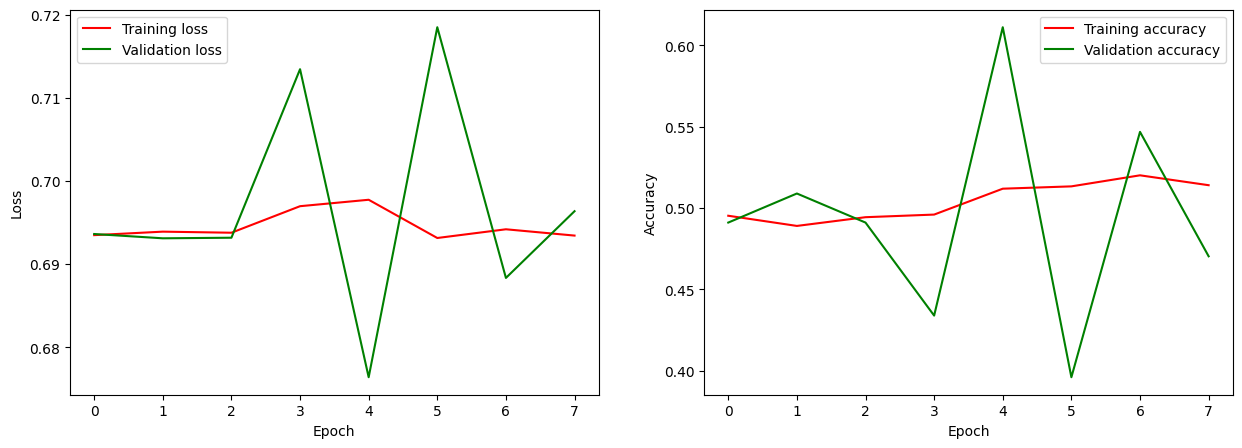

In [56]:
# Function to plot training history
def plot(hist):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], 'r', label='Training loss')
    plt.plot(hist.history['val_loss'], 'g', label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['accuracy'], 'r', label='Training accuracy')
    plt.plot(hist.history['val_accuracy'], 'g', label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Plot training history
plot(hist)

In [59]:
 accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy", accuracy)

Accuracy 0.6111508011817932


In [53]:
# Make predictions using the model
y_pred = model.predict(X_test)

# Adjust threshold for binary classification
y_pred = (y_pred > 0.5).astype(int)

# Calculate metrics
precision_depression = precision_score(y_test, y_pred, pos_label=1)
recall_depression = recall_score(y_test, y_pred, pos_label=1)
f1_depression = f1_score(y_test, y_pred, pos_label=1)

precision_non_depression = precision_score(y_test, y_pred, pos_label=0)
recall_non_depression = recall_score(y_test, y_pred, pos_label=0)
f1_non_depression = f1_score(y_test, y_pred, pos_label=0)

# Print metrics
print(f"Precision for Depression: {precision_depression:.4f}")
print(f"Recall for Depression: {recall_depression:.4f}")
print(f"F1 Score for Depression: {f1_depression:.4f}")
print()
print(f"Precision for Non-Depression: {precision_non_depression:.4f}")
print(f"Recall for Non-Depression: {recall_non_depression:.4f}")
print(f"F1 Score for Non-Depression: {f1_non_depression:.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step
Precision for Depression: 0.6053
Recall for Depression: 0.5983
F1 Score for Depression: 0.6018

Precision for Non-Depression: 0.6167
Recall for Non-Depression: 0.6236
F1 Score for Non-Depression: 0.6201


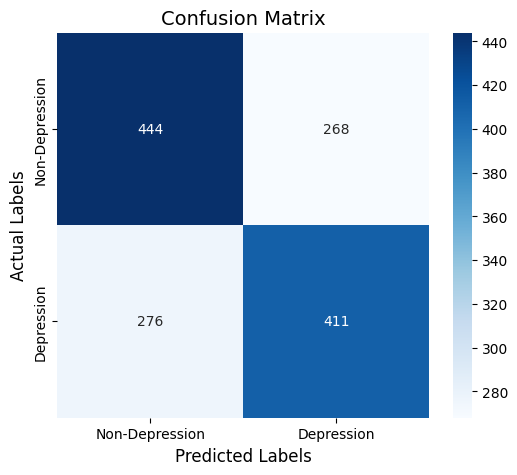

Confusion Matrix:
[[444 268]
 [276 411]]


In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Depression', 'Depression'], yticklabels=['Non-Depression', 'Depression'])
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('Actual Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.show()

# Print confusion matrix as text
print("Confusion Matrix:")
print(conf_matrix)
